In [28]:
#pip install torch

In [29]:
#!pip install simpletransformers

In [30]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn

In [31]:
from google.colab import files
from google.colab import drive

In [32]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
test = pd.read_csv("/content/drive/MyDrive/Elena/sentiment-topic-test.tsv", sep = '\t')

In [34]:
test['topic'].tolist()

['sports',
 'sports',
 'book',
 'book',
 'book',
 'movie',
 'movie',
 'sports',
 'sports',
 'movie',
 'book',
 'book',
 'movie',
 'sports',
 'sports',
 'movie',
 'movie',
 'book']

In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  18 non-null     int64 
 1   sentence     18 non-null     object
 2   sentiment    18 non-null     object
 3   topic        18 non-null     object
dtypes: int64(1), object(3)
memory usage: 708.0+ bytes


In [36]:
test.rename(columns = {'topic':'Category'}, inplace = True) #making sure test data matches training data

In [37]:
test['Category'].replace(['movie', 'sports', 'book'],
                        [0, 1, 2], inplace=True)

<ipython-input-37-572b1878020a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Category'].replace(['movie', 'sports', 'book'],
<ipython-input-37-572b1878020a>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Category'].replace(['movie', 'sports', 'book'],


In [38]:
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('/content/drive/MyDrive/Elena/BBC_News_Train.csv')
selected_categories = df["Category"].unique()[:3]

df_filtered = df[df["Category"].isin(selected_categories)].copy()

X = df_filtered["Text"]
y = df_filtered["Category"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
train_data = pd.DataFrame({"text": X_train, "label": y_train})
test_data = pd.DataFrame({"text": X_test, "label": y_test})

In [40]:
# Show category mappings
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print results
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print("Category Mapping:", category_mapping)

Training samples: 696, Testing samples: 175
Category Mapping: {'business': np.int64(0), 'politics': np.int64(1), 'tech': np.int64(2)}


In [41]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase.
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [42]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(X_train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 22 steps.


In [43]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args=model_args, use_cuda=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
%%time
_, history = model.train_model(train_data, eval_df=test_data)

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 4 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 5 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 6 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 7 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 8 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 9 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 10 of 10:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


CPU times: user 2min 5s, sys: 57.3 s, total: 3min 3s
Wall time: 6min 45s


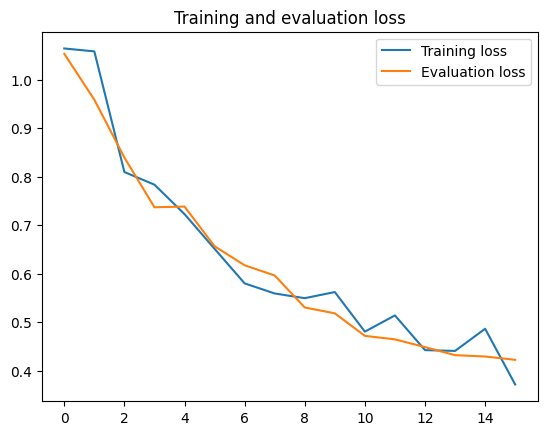

In [45]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [49]:
result, model_outputs, wrong_predictions = model.eval_model(test_data)
result

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


{'mcc': np.float64(0.9402448833978807), 'eval_loss': 0.4224322438240051}

In [50]:
predicted, probabilities = model.predict(test_data["text"].tolist())
test_data["predicted"] = predicted

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [51]:
print(classification_report(test_data["label"], test_data["predicted"]))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95        68
           1       0.98      0.95      0.96        55
           2       1.00      0.94      0.97        52

    accuracy                           0.96       175
   macro avg       0.97      0.96      0.96       175
weighted avg       0.96      0.96      0.96       175

